In [47]:

'''REQUIRED LIBRARIES'''
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import math


import plotly.graph_objs as go


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, Input, UpSampling2D, ZeroPadding2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K


## Check active GPU 

In [48]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## MAIN MODEL FOR GREYSCALE IMAGES

### Load Data

In [49]:
#Set the path to the folder containing the image as required

train_path_4 = '..//raw_data/archive/cropped-seeing-3d-chairs-100x100-86k/'

In [50]:
def paginate_folder(dir_path, page_no, page_size):
    '''
    Goes though folder and returns lists of the containing filenames in pages
    dirpath: folder location 
    page_size: how many files to include in a page
    page_no: which page to return
    '''
    
    all_file_names = os.listdir(dir_path)
    all_file_names.sort()
    
    
    # page 1, page size 5000 -> first file index 0
    # page 2, page size 5000 -> first file index 2000
    first_file_in_page_index = (page_no - 1) * page_size
    
    page = all_file_names[first_file_in_page_index : first_file_in_page_index + page_size]
    
    x =[]
    for filename in page:
        x.append(os.path.join(dir_path, filename))
    
    return x
    
    

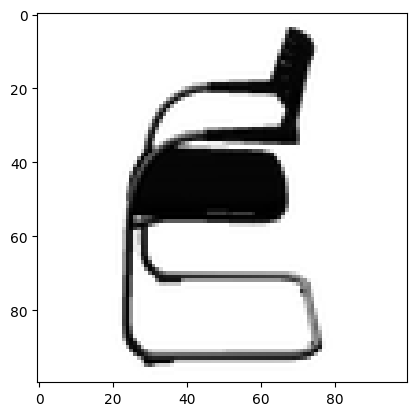

In [51]:
#testing paginate_folder
page = paginate_folder(train_path_4,1,10)

plt.imshow(mpimg.imread(page[0]))
plt.show();

In [52]:
mpimg.imread(page[0]).shape

(100, 100, 4)

In [53]:
def page_numbers(dir_path, page_size):
    '''determine how many pages required for specific folder 
    based on how many files included in each file
    '''
    all_file_names = os.listdir(dir_path)
    return math.ceil( len(all_file_names)/page_size)

In [54]:

page_num = page_numbers(train_path_4,10)

In [55]:
# Declare page size - will be applied 
page_size =1000

In [56]:
# Show pages with their size
num_pages = page_numbers(train_path_4, page_size)
for page_num in range(1, num_pages):
    page_filenames =paginate_folder(train_path_4,page_num, page_size)
    print(f'page {page_num}, files found: {len(page_filenames)}')
    

page 1, files found: 1000
page 2, files found: 1000
page 3, files found: 1000
page 4, files found: 1000
page 5, files found: 1000
page 6, files found: 1000
page 7, files found: 1000
page 8, files found: 1000
page 9, files found: 1000
page 10, files found: 1000
page 11, files found: 1000
page 12, files found: 1000
page 13, files found: 1000
page 14, files found: 1000
page 15, files found: 1000
page 16, files found: 1000
page 17, files found: 1000
page 18, files found: 1000
page 19, files found: 1000
page 20, files found: 1000
page 21, files found: 1000
page 22, files found: 1000
page 23, files found: 1000
page 24, files found: 1000
page 25, files found: 1000
page 26, files found: 1000
page 27, files found: 1000
page 28, files found: 1000
page 29, files found: 1000
page 30, files found: 1000
page 31, files found: 1000
page 32, files found: 1000
page 33, files found: 1000
page 34, files found: 1000
page 35, files found: 1000
page 36, files found: 1000
page 37, files found: 1000
page 38, f

In [57]:
def filepath_to_preprocessed_array(filepath): 
    '''
    takes image filepath and returns preprocessed array
    preprocessing includes: 
    -resizing to 100x100
    -converting to greyscale
    -normalizing
    '''
    
    # Check if the file is an image
    if filepath.endswith(".jpg") or filepath.endswith(".png"):
        # Load the image
        img = Image.open(filepath)
        # Resize the image to (100, 100) ---- comment out if not needed
        #img = img.resize((100,100))
        # Convert the image to RGB if it's not already in RGB format ---- comment out if not needed
        #if img.mode != 'RGB':
        #img = img.convert('RGB').convert('L')
        
            # Convert image to RGBA mode if not already
        if img.mode != 'RGBA':
            img = img.convert('RGBA')

        # Create a white background image of the same size
        white_bg = Image.new('RGBA', img.size, (255, 255, 255, 255))

        # Composite the original image over the white background
        result = Image.alpha_composite(white_bg, img)

        # Convert the result to greyscale
        result = result.convert('L')

        # Resize the image to (100, 100)
        result = result.resize((100, 100))

        
        result = np.array(result)
        result = result/255.0
        # return image
        return result

In [58]:
#quick ckeck 
filepath_to_preprocessed_array('..//raw_data/archive/rendered_chairs/folder_b/image2.png').shape

(100, 100)

In [59]:

def filepaths_to_preprocessed_arrays(filepaths):
    '''
    returns an array containing images as arrays
    '''
    result = []
    for f in filepaths:
        result.append(filepath_to_preprocessed_array(f))
    return np.array(result)


### Building the Model

In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense, ZeroPadding2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def sampling(args):
    '''Reparametrization trick z-mu +sigma +epsilon'''
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_encoder_vae(input_shape, encoding_dim):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    flattened = Flatten()(x)
    z_mean = Dense(encoding_dim, name='z_mean')(flattened)
    z_log_var = Dense(encoding_dim, name='z_log_var')(flattened)
    z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([z_mean, z_log_var])
    return Model(input_img, [z_mean, z_log_var, z])

def build_decoder_vae(encoded_dim, input_shape):
    input_encoded = Input(shape=(encoded_dim,))
    x = Dense(12 * 12 * 128, activation='relu')(input_encoded)  # Calculate the number of neurons to match the desired shape
    x = Reshape((12, 12, 128))(x)  # Reshape to match the shape after the last pooling layer in the encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Change padding to 'same'
    x = UpSampling2D((2, 2))(x)
    x = ZeroPadding2D(2)(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Change padding to 'same'
    return Model(input_encoded, decoded)

# Define input shape and encoding dimension
input_shape = (100, 100, 1)
encoding_dim = 100  # Example encoding dimension

# Build encoder and decoder
encoder_vae = build_encoder_vae(input_shape, encoding_dim)
print(encoder_vae.output_shape)

decoder_vae = build_decoder_vae(encoding_dim, input_shape)

# Combine encoder and decoder into autoencoder
input_img = Input(shape=input_shape)
z_mean, z_log_var, z = encoder_vae(input_img)
decoded = decoder_vae(z)
autoencoder_vae = Model(input_img, decoded)

# Define the VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(decoded))
reconstruction_loss *= input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
autoencoder_vae.add_loss(vae_loss)

# Compile the VAE
autoencoder_vae.compile(optimizer='adam')

[(None, 100), (None, 100), (None, 100)]


### Train the model

In [61]:
page_size = 2000
num_pages = page_numbers(train_path_4, page_size)
for page_num in range(1, num_pages):
    page_filenames = paginate_folder(train_path_4,page_num, page_size)
    training_page = filepaths_to_preprocessed_arrays(page_filenames)
    
    print (f'fitting page number {page_num} out of {num_pages}')
    autoencoder_vae.fit(training_page,training_page, epochs=20, batch_size=32, shuffle=True)

fitting page number 1 out of 44
Epoch 1/20
63/63 [==============================] - 4s 29ms/step - loss: 4159.5029
Epoch 2/20
63/63 [==============================] - 1s 24ms/step - loss: 3142.3389
Epoch 3/20
63/63 [==============================] - 1s 24ms/step - loss: 2699.2102
Epoch 4/20
63/63 [==============================] - 2s 25ms/step - loss: 2457.6279
Epoch 5/20
63/63 [==============================] - 2s 24ms/step - loss: 2316.0959
Epoch 6/20
63/63 [==============================] - 2s 25ms/step - loss: 2196.3816
Epoch 7/20
63/63 [==============================] - 2s 24ms/step - loss: 2108.0190
Epoch 8/20
63/63 [==============================] - 2s 24ms/step - loss: 2045.9303
Epoch 9/20
63/63 [==============================] - 2s 24ms/step - loss: 1993.4016
Epoch 10/20
63/63 [==============================] - 2s 25ms/step - loss: 1942.7982
Epoch 11/20
63/63 [==============================] - 2s 25ms/step - loss: 1907.2393
Epoch 12/20
63/63 [==============================] - 

63/63 [==============================] - 2s 24ms/step - loss: 1344.1613
Epoch 18/20
63/63 [==============================] - 2s 24ms/step - loss: 1347.0221
Epoch 19/20
63/63 [==============================] - 2s 24ms/step - loss: 1342.2955
Epoch 20/20
63/63 [==============================] - 2s 24ms/step - loss: 1337.6472
fitting page number 6 out of 44
Epoch 1/20
63/63 [==============================] - 2s 24ms/step - loss: 1749.6146
Epoch 2/20
63/63 [==============================] - 2s 24ms/step - loss: 1623.7184
Epoch 3/20
63/63 [==============================] - 2s 24ms/step - loss: 1575.8590
Epoch 4/20
63/63 [==============================] - 2s 24ms/step - loss: 1546.2098
Epoch 5/20
63/63 [==============================] - 2s 24ms/step - loss: 1532.0919
Epoch 6/20
63/63 [==============================] - 2s 24ms/step - loss: 1511.4768
Epoch 7/20
63/63 [==============================] - 2s 24ms/step - loss: 1501.3992
Epoch 8/20
63/63 [==============================] - 2s 24ms/ste

63/63 [==============================] - 2s 24ms/step - loss: 1418.3275
Epoch 14/20
63/63 [==============================] - 2s 24ms/step - loss: 1417.3629
Epoch 15/20
63/63 [==============================] - 2s 24ms/step - loss: 1409.9921
Epoch 16/20
63/63 [==============================] - 2s 24ms/step - loss: 1407.9508
Epoch 17/20
63/63 [==============================] - 2s 24ms/step - loss: 1406.1743
Epoch 18/20
63/63 [==============================] - 2s 24ms/step - loss: 1403.0463
Epoch 19/20
63/63 [==============================] - 2s 24ms/step - loss: 1401.7659
Epoch 20/20
63/63 [==============================] - 2s 24ms/step - loss: 1397.0469
fitting page number 11 out of 44
Epoch 1/20
63/63 [==============================] - 2s 24ms/step - loss: 1603.4792
Epoch 2/20
63/63 [==============================] - 2s 24ms/step - loss: 1503.7786
Epoch 3/20
63/63 [==============================] - 2s 24ms/step - loss: 1461.4202
Epoch 4/20
63/63 [==============================] - 2s 24m

63/63 [==============================] - 1s 24ms/step - loss: 1374.8246
Epoch 10/20
63/63 [==============================] - 2s 24ms/step - loss: 1367.7450
Epoch 11/20
63/63 [==============================] - 2s 24ms/step - loss: 1359.9425
Epoch 12/20
63/63 [==============================] - 2s 24ms/step - loss: 1356.3284
Epoch 13/20
63/63 [==============================] - 2s 24ms/step - loss: 1354.1388
Epoch 14/20
63/63 [==============================] - 1s 24ms/step - loss: 1348.5028
Epoch 15/20
63/63 [==============================] - 2s 24ms/step - loss: 1347.4189
Epoch 16/20
63/63 [==============================] - 2s 24ms/step - loss: 1346.7146
Epoch 17/20
63/63 [==============================] - 2s 24ms/step - loss: 1339.1414
Epoch 18/20
63/63 [==============================] - 2s 24ms/step - loss: 1338.4071
Epoch 19/20
63/63 [==============================] - 1s 24ms/step - loss: 1335.9521
Epoch 20/20
63/63 [==============================] - 1s 24ms/step - loss: 1335.2296
fitt

63/63 [==============================] - 2s 24ms/step - loss: 1344.9050
Epoch 6/20
63/63 [==============================] - 2s 24ms/step - loss: 1334.7059
Epoch 7/20
63/63 [==============================] - 1s 24ms/step - loss: 1324.6295
Epoch 8/20
63/63 [==============================] - 2s 24ms/step - loss: 1319.4965
Epoch 9/20
63/63 [==============================] - 2s 24ms/step - loss: 1314.2456
Epoch 10/20
63/63 [==============================] - 2s 24ms/step - loss: 1304.0682
Epoch 11/20
63/63 [==============================] - 2s 24ms/step - loss: 1299.9110
Epoch 12/20
63/63 [==============================] - 2s 24ms/step - loss: 1295.1208
Epoch 13/20
63/63 [==============================] - 1s 24ms/step - loss: 1294.4880
Epoch 14/20
63/63 [==============================] - 1s 24ms/step - loss: 1289.2217
Epoch 15/20
63/63 [==============================] - 2s 24ms/step - loss: 1287.8142
Epoch 16/20
63/63 [==============================] - 2s 24ms/step - loss: 1283.1654
Epoch 17

63/63 [==============================] - 1s 24ms/step - loss: 1517.5393
Epoch 2/20
63/63 [==============================] - 1s 24ms/step - loss: 1439.9141
Epoch 3/20
63/63 [==============================] - 2s 24ms/step - loss: 1404.4763
Epoch 4/20
63/63 [==============================] - 2s 24ms/step - loss: 1387.5563
Epoch 5/20
63/63 [==============================] - 1s 24ms/step - loss: 1368.3361
Epoch 6/20
63/63 [==============================] - 1s 24ms/step - loss: 1360.4906
Epoch 7/20
63/63 [==============================] - 1s 24ms/step - loss: 1351.7284
Epoch 8/20
63/63 [==============================] - 2s 24ms/step - loss: 1343.2112
Epoch 9/20
63/63 [==============================] - 1s 24ms/step - loss: 1340.7228
Epoch 10/20
63/63 [==============================] - 1s 24ms/step - loss: 1335.0427
Epoch 11/20
63/63 [==============================] - 2s 24ms/step - loss: 1330.4464
Epoch 12/20
63/63 [==============================] - 2s 24ms/step - loss: 1328.4579
Epoch 13/20


63/63 [==============================] - 1s 24ms/step - loss: 1421.9019
Epoch 18/20
63/63 [==============================] - 1s 24ms/step - loss: 1420.8226
Epoch 19/20
63/63 [==============================] - 1s 24ms/step - loss: 1418.6545
Epoch 20/20
63/63 [==============================] - 1s 24ms/step - loss: 1416.0061
fitting page number 30 out of 44
Epoch 1/20
63/63 [==============================] - 2s 24ms/step - loss: 1684.2377
Epoch 2/20
63/63 [==============================] - 1s 24ms/step - loss: 1600.9819
Epoch 3/20
63/63 [==============================] - 1s 24ms/step - loss: 1568.2567
Epoch 4/20
63/63 [==============================] - 1s 24ms/step - loss: 1547.7770
Epoch 5/20
63/63 [==============================] - 2s 24ms/step - loss: 1537.5253
Epoch 6/20
63/63 [==============================] - 2s 24ms/step - loss: 1523.5099
Epoch 7/20
63/63 [==============================] - 1s 24ms/step - loss: 1514.2999
Epoch 8/20
63/63 [==============================] - 2s 24ms/st

63/63 [==============================] - 1s 24ms/step - loss: 1359.0558
Epoch 14/20
63/63 [==============================] - 1s 24ms/step - loss: 1354.6373
Epoch 15/20
63/63 [==============================] - 1s 23ms/step - loss: 1353.0016
Epoch 16/20
63/63 [==============================] - 1s 24ms/step - loss: 1350.5481
Epoch 17/20
63/63 [==============================] - 1s 23ms/step - loss: 1347.3075
Epoch 18/20
63/63 [==============================] - 1s 23ms/step - loss: 1345.6689
Epoch 19/20
63/63 [==============================] - 1s 23ms/step - loss: 1345.4768
Epoch 20/20
63/63 [==============================] - 1s 23ms/step - loss: 1346.0869
fitting page number 35 out of 44
Epoch 1/20
63/63 [==============================] - 2s 24ms/step - loss: 1548.6989
Epoch 2/20
63/63 [==============================] - 1s 24ms/step - loss: 1475.7950
Epoch 3/20
63/63 [==============================] - 1s 23ms/step - loss: 1444.4213
Epoch 4/20
63/63 [==============================] - 1s 23m

63/63 [==============================] - 1s 24ms/step - loss: 1370.5787
Epoch 10/20
63/63 [==============================] - 2s 25ms/step - loss: 1366.4105
Epoch 11/20
63/63 [==============================] - 2s 24ms/step - loss: 1362.1179
Epoch 12/20
63/63 [==============================] - 1s 23ms/step - loss: 1359.6002
Epoch 13/20
63/63 [==============================] - 2s 24ms/step - loss: 1359.0458
Epoch 14/20
63/63 [==============================] - 1s 23ms/step - loss: 1355.7147
Epoch 15/20
63/63 [==============================] - 1s 23ms/step - loss: 1351.3027
Epoch 16/20
63/63 [==============================] - 1s 23ms/step - loss: 1346.2574
Epoch 17/20
63/63 [==============================] - 2s 24ms/step - loss: 1344.9884
Epoch 18/20
63/63 [==============================] - 1s 23ms/step - loss: 1342.5502
Epoch 19/20
63/63 [==============================] - 1s 23ms/step - loss: 1338.5759
Epoch 20/20
63/63 [==============================] - 1s 24ms/step - loss: 1338.3129
fitt

### Visualize results

#### Show input images next to their reconstructed outputs

In [62]:

def plot_reconstructions(model, images, n_images=5):
    '''
    function that iputs images passes them though an autoencoder model and plots them next to the reconstructed images
    '''
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="gray")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="gray")
        plt.axis("off")


working on page number 1
1/1 [==============================] - 0s 178ms/step
working on page number 2
1/1 [==============================] - 0s 21ms/step


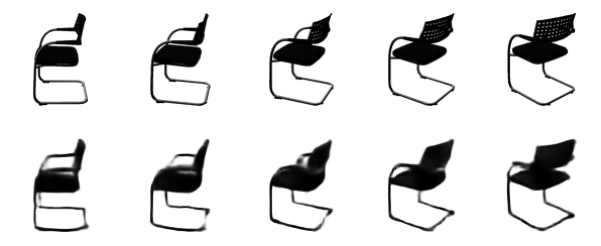

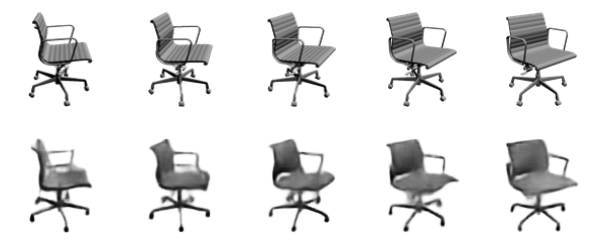

In [63]:
### pass 5 images from the first two pages for testing
for page_num in range(1, 3):
    page_filenames = paginate_folder(train_path_4,page_num, page_size)
    training_page = filepaths_to_preprocessed_arrays(page_filenames)
    print (f'working on page number {page_num}')
    
    plot_reconstructions(autoencoder_vae,training_page,5)

#### Create random outputs

In [64]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="gray")
        plt.axis("off")

In [73]:
#create 21 random vector of the latent size and use the decoder to reconstruct images
codings = tf.random.normal(shape=[3 * 7, 100]) # for latent size =100
random_images_vae = decoder_vae(codings).numpy()

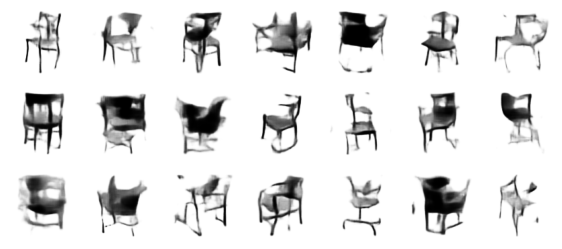

In [74]:
plot_multiple_images(random_images_vae, 7)
plt.show()

#### Interpolate between images

In [75]:
for page_num in range(1, 2):
    page_filenames = paginate_folder(train_path_4,page_num, page_size)
    training_page = filepaths_to_preprocessed_arrays(page_filenames)
    print (type(training_page))
    
    image1 = training_page[20]  # Input image 1 - Replace with actual indices
    image2 = training_page[610]  # Input image 2-  Replace with actual indices
    print(type(image1))
    print(image1.shape)


    # Encode the images
    _, _, encoding1 = encoder_vae.predict(np.array([image1]))
    _, _, encoding2 = encoder_vae.predict(np.array([image2]))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(100, 100)
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


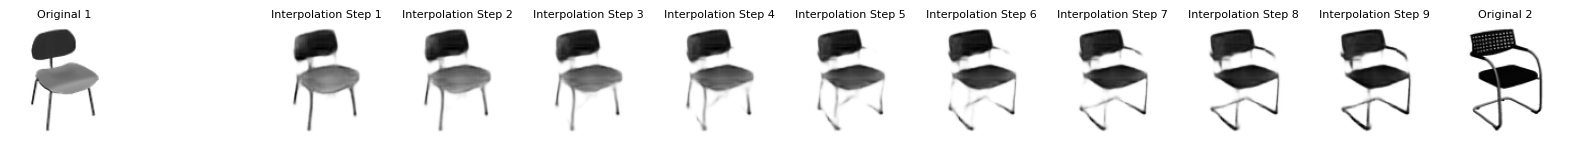

In [76]:
# Interpolate between the encodings
interpolated_encodings = []
for i in range(10):
    alpha = i / 10.0
    interpolated_encoding = alpha * encoding1 + (1 - alpha) * encoding2
    interpolated_encodings.append(interpolated_encoding)

# Decode the interpolated encodings
reconstructed_images = []
for interpolated_encoding in interpolated_encodings:
    interpolated_encoding_reshaped = interpolated_encoding.reshape((1, 100))  # Reshape to (1, 100)
    reconstructed_image = decoder_vae.predict(interpolated_encoding_reshaped)
    reconstructed_images.append(reconstructed_image.squeeze())

# Plot the original images and their corresponding reconstructions interleaved
plt.figure(figsize=(20, 10))

plt.subplot(1, 12, 1)
plt.imshow(image2,cmap='gray')
plt.title('Original 1',fontsize=8)
plt.axis('off')

for i, reconstructed_image in enumerate(reconstructed_images):
    plt.subplot(1, 12, i + 3)
    plt.imshow(reconstructed_image.squeeze(),cmap='gray')
    plt.title(f'Interpolation Step {i + 1}',fontsize=8)
    plt.axis('off')
    
plt.subplot(1, 12, 12)
plt.imshow(image1,cmap='gray')
plt.title('Original 2',fontsize=8)
plt.axis('off')

plt.show()


#### Interpolate between images that the model hasn't seen before

In [94]:
img1 = filepath_to_preprocessed_array('..//raw_data/archive/rendered_chairs/test/image124.jpg')
img2 = filepath_to_preprocessed_array('..//raw_data/archive/rendered_chairs/test/image241.jpg')

In [95]:
type(img1)

numpy.ndarray

In [96]:
_,_,encoding1 =encoder_vae.predict(np.array([img1]))
_,_,encoding2 =encoder_vae.predict(np.array([img2]))

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


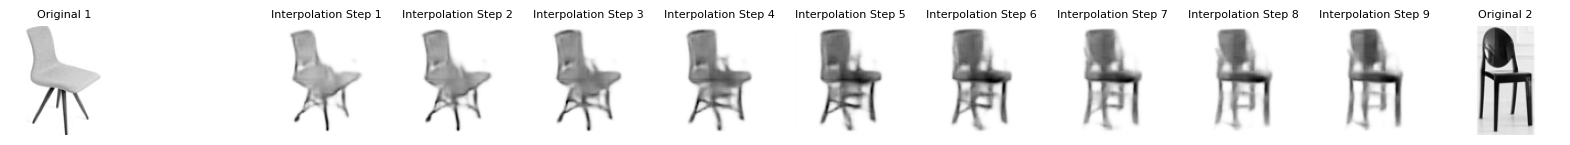

In [97]:
interpolated_encodings = []
for i in range(10):
    alpha = i / 10.0
    interpolated_encoding = alpha * encoding1 + (1 - alpha) * encoding2
    interpolated_encodings.append(interpolated_encoding)

# Decode the interpolated encodings
reconstructed_images = []
for interpolated_encoding in interpolated_encodings:
    interpolated_encoding_reshaped = interpolated_encoding.reshape((1, 100))  # Reshape to (1, 100)
    reconstructed_image = decoder_vae.predict(interpolated_encoding_reshaped)
    reconstructed_images.append(reconstructed_image.squeeze())

# Plot the original images and their corresponding reconstructions interleaved
plt.figure(figsize=(20, 10))

plt.subplot(1, 12, 1)
plt.imshow(img2,cmap='gray')
plt.title('Original 1',fontsize=8)
plt.axis('off')

for i, reconstructed_image in enumerate(reconstructed_images):
    plt.subplot(1, 12, i + 3)
    plt.imshow(reconstructed_image.squeeze(),cmap='gray')
    plt.title(f'Interpolation Step {i + 1}',fontsize=8)
    plt.axis('off')
    
plt.subplot(1, 12, 12)
plt.imshow(img1,cmap='gray')
plt.title('Original 2',fontsize=8)
plt.axis('off')

plt.show()


-----------------------------------

## MODEL FOR COLOUR IMAGES

In [27]:

def sampling(args):
    '''Reparametrization trick z-mu +sigma +epsilon'''
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_encoder_vae(input_shape, encoding_dim):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    flattened = Flatten()(x)
    z_mean = Dense(encoding_dim, name='z_mean')(flattened)
    z_log_var = Dense(encoding_dim, name='z_log_var')(flattened)
    z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([z_mean, z_log_var])
    return Model(input_img, [z_mean, z_log_var, z])

def build_decoder_vae(encoded_dim, input_shape):
    input_encoded = Input(shape=(encoded_dim,))
    x = Dense(12 * 12 * 128, activation='relu')(input_encoded)  # Calculate the number of neurons to match the desired shape
    x = Reshape((12, 12, 128))(x)  # Reshape to match the shape after the last pooling layer in the encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Change padding to 'same'
    x = UpSampling2D((2, 2))(x)
    x = ZeroPadding2D(2)(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Change padding to 'same'
    return Model(input_encoded, decoded)

# Define input shape and encoding dimension
input_shape = (100, 100, 3)  # Adjusted for colored images
encoding_dim = 100  # Example encoding dimension

# Build encoder and decoder
encoder_vae = build_encoder_vae(input_shape, encoding_dim)
print(encoder_vae.output_shape)

decoder_vae = build_decoder_vae(encoding_dim, input_shape)

# Combine encoder and decoder into autoencoder
input_img = Input(shape=input_shape)
z_mean, z_log_var, z = encoder_vae(input_img)
decoded = decoder_vae(z)
autoencoder_vae = Model(input_img, decoded)

# Define the VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(decoded))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]  # Adjusted for colored images
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
autoencoder_vae.add_loss(vae_loss)

# Compile the VAE
autoencoder_vae.compile(optimizer='adam')


[(None, 100), (None, 100), (None, 100)]


In [28]:
def filepath_to_preprocessed_array_colour(filepath): 

    # Check if the file is an image
    if filepath.endswith(".jpg") or filepath.endswith(".png"):
        # Load the image
        img = Image.open(filepath)
        
        # Convert the image to RGBA mode if it's not already in RGBA
        img = img.convert("RGBA")

        # Create a new blank white image with the same size as the original image
        white_img = Image.new("RGB", img.size, (255, 255, 255))            
        white_img = white_img.convert("RGBA")

        # Composite the original image onto the white image, using the alpha channel as a mask
        result = Image.alpha_composite(white_img, img)



        # Resize the image to (100, 100) ---- comment out if not needed
        result = result.resize((100,100))
        # Convert the image to RGB if it's not already in RGB format ---- comment out if not needed
        #if img.mode != 'RGB':
            #img = img.convert('RGB')
        
        result = np.array(result)
        result = result/255.0
        # return image
        return result

In [29]:
filepath_to_preprocessed_array_colour('..//raw_data/archive/rendered_chairs/folder_b/image2.png').shape

(100, 100, 4)

In [30]:
def filepaths_to_preprocessed_arrays_colour(filepaths):
    result = []
    for f in filepaths:
        result.append(filepath_to_preprocessed_array_colour(f))
    return np.array(result)

In [31]:
page_size=2000
num_pages = page_numbers(train_path_4, page_size)
for page_num in range(1, num_pages):
    #print(f'page_num {page_num}')
    page_filenames = paginate_folder(train_path_4,page_num, page_size)
    #print(f'page_filenames {page_filenames}')
    training_page = filepaths_to_preprocessed_arrays_colour(page_filenames)
    
    print (f'fitting page number {page_num} out of {num_pages}')
    autoencoder_vae.fit(training_page,training_page, epochs=10, batch_size=8, shuffle=True)

fitting page number 1 out of 44
Epoch 1/10


ValueError: in user code:

    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/alexp/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_5" is incompatible with the layer: expected shape=(None, 100, 100, 3), found shape=(8, 100, 100, 4)
